<a href="https://colab.research.google.com/github/MitPitt/msu-nn-special-course/blob/main/%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Требуется найти параметры системы Хищник-Жертва при помощи метода MCMC. 

 

Результатом является записная книжка Python Notebook в которой: 
- Задаются параметры системы Хищник-Жертва 
- Решается прямая задача и генерируются данные 
- К данными применяется зашумление 
- Методом MCMC оцениваются параметры системы по зашумленным данным 

 

Возможно использования пакета РуMC или любого другого. 

 

При решении задачи имеет смысл взять один из параметров равным 1. 

In [176]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Модель Лотки-Вольтерры

![title](https://wikimedia.org/api/rest_v1/media/math/render/svg/ac308477f394f9ea2eeddcf3d76e847cd79e7a39)

![title](https://wikimedia.org/api/rest_v1/media/math/render/svg/f80ad07bbcd6d675146ea95c567d59784d99d1d5)


In [177]:
def lotka(state, t, alpha, beta, gamma, delta):
    x, y = state
    return (alpha - beta*y)*x, (-gamma + delta*x)*y

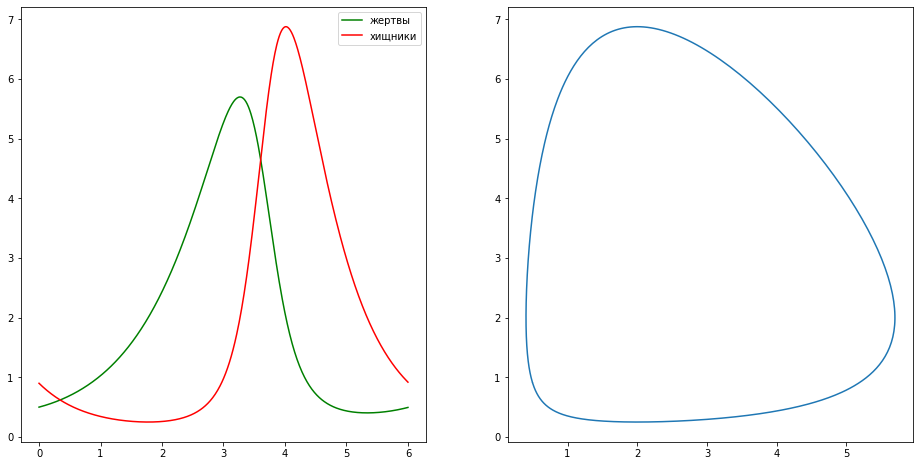

In [178]:
alpha, beta, gamma, delta = 1, 0.5, 1.5, 0.75

t_stop = 6
dt = 0.01
iters = int(t_stop/dt)
t = np.linspace(0, t_stop, iters)

state_0 = [0.5, 0.9]

solution = odeint(lotka, state_0, t, args=(alpha, beta, gamma, delta))

x = solution[:,0]
y = solution[:,1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

ax[0].plot(t, x, 'g', label='жертвы')
ax[0].plot(t, y, 'r', label='хищники')
ax[0].legend()

ax[1].plot(x, y, label='фазовая траектория')[0]

plt.show()

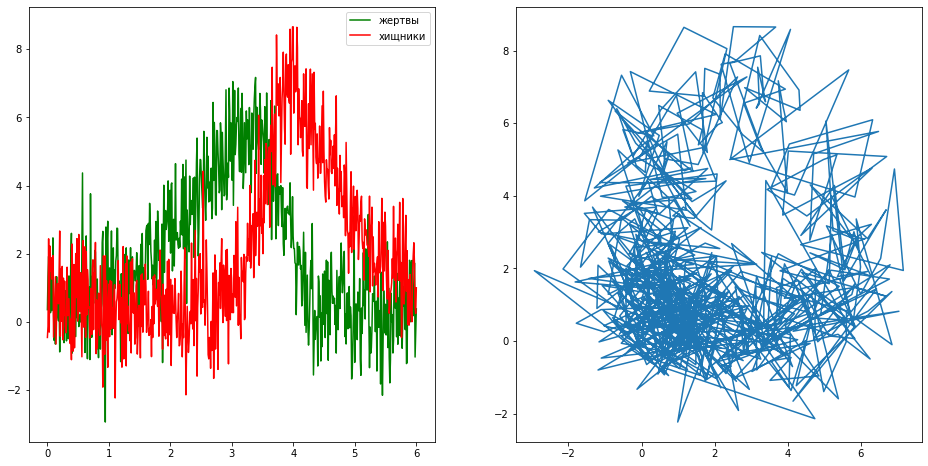

In [179]:
x_noise = x + np.random.normal(size=len(x))
y_noise = y + np.random.normal(size=len(y))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

ax[0].plot(t, x_noise, 'g', label='жертвы')
ax[0].plot(t, y_noise, 'r', label='хищники')
ax[0].legend()

ax[1].plot(x_noise, y_noise)[0]

plt.show()

## MCMC

Алгоритм Метрополиса — Гастингса

In [180]:
def distance(x_noise, y_noise, x_simulated, y_simulated):
    return np.sum(np.abs(x_simulated - x_noise) + np.abs(y_simulated - y_noise))

dist_limit = distance(x_noise, y_noise, x, y)

In [181]:
low, high = 0.01, 2
scale = 0.1

In [182]:
def proposal(b, c, d):
    #alpha = np.random.normal(loc=a, scale=scale)
    beta = np.random.normal(loc=b, scale=scale)
    gamma = np.random.normal(loc=c, scale=scale)
    delta = np.random.normal(loc=d, scale=scale)
    return beta, gamma, delta

In [183]:
def prob(beta, gamma, delta, beta_i, gamma_i, delta_i):
    n1 = stats.uniform(low, high).pdf(beta) * stats.uniform(low, high).pdf(gamma) * stats.uniform(low, high).pdf(delta)
    n2 = stats.norm(beta, scale).pdf(beta_i) * stats.norm(gamma, scale).pdf(gamma_i) * stats.norm(delta, scale).pdf(delta_i)

    d1 = stats.uniform(low, high).pdf(beta_i) * stats.uniform(low, high).pdf(gamma_i) * stats.uniform(low, high).pdf(delta_i)
    d2 = stats.norm(beta_i, scale).pdf(beta) * stats.norm(gamma_i, scale).pdf(gamma) * stats.norm(delta_i, scale).pdf(delta)

    return (n1*n2)/(d1*d2)

In [184]:
iterations = 10000

#закрепляем alpha=1
alpha = 1
#a_chain = np.zeros(iterations)
#a_chain[0] = np.random.uniform(low, high)

beta_chain = np.zeros(iterations)
beta_chain[0] = 1

gamma_chain = np.zeros(iterations)
gamma_chain[0] = 1

delta_chain = np.zeros(iterations)
delta_chain[0] = 1

s,ss,sss=0,0,0

for i in range(iterations-1):
    beta, gamma, delta = proposal(beta_chain[i], gamma_chain[i], delta_chain[i])

    simulation = odeint(lotka, state_0, t, args=(alpha, beta, gamma, delta))
    x_simulated = simulation[:,0]
    y_simulated = simulation[:,1]
    
    if distance(x_noise, y_noise, x_simulated, y_simulated) < (dist_limit * 2):
        if np.random.random() < prob(beta, gamma, delta, beta_chain[i], gamma_chain[i], delta_chain[i]):
            s +=1
            #alpha_chain[i+1] = alpha
            beta_chain[i+1] = beta
            gamma_chain[i+1] = gamma
            delta_chain[i+1] = delta
        else:
            ss +=1
            #alpha_chain[i+1] = alpha_chain[i]
            beta_chain[i+1] = beta_chain[i]
            gamma_chain[i+1] = gamma_chain[i]
            delta_chain[i+1] = delta_chain[i]

    else:
        sss +=1
        #alpha_chain[i+1] = alpha_chain[i]
        beta_chain[i+1] = beta_chain[i]
        gamma_chain[i+1] = gamma_chain[i]
        delta_chain[i+1] = delta_chain[i]

print(s,ss,sss)

7781 408 1810


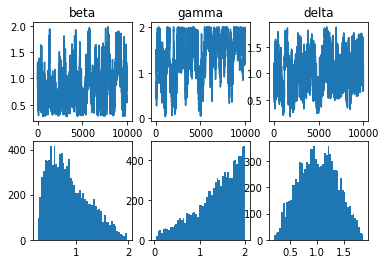

In [185]:
plt.subplot(2,3,1)
plt.plot(beta_chain)
plt.title('beta')

plt.subplot(2,3,2)
plt.plot(gamma_chain)
plt.title('gamma')

plt.subplot(2,3,3)
plt.plot(delta_chain)
plt.title('delta')

plt.subplot(2,3,4)
plt.hist(beta_chain, bins=50)

plt.subplot(2,3,5)
plt.hist(gamma_chain, bins=50)

plt.subplot(2,3,6)
plt.hist(delta_chain, bins=50)

plt.show()

Оригинальные параметры были alpha, beta, gamma, delta = 1, 0.5, 1.5, 0.75

Такой простой алгоритм аппроксимирует параметры неидеально, но сойдет.